In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:

import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:

# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '/content/drive/My Drive/'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
from mrcnn import visualize1
from mrcnn import model1
import mrcnn.model1 as modellib

Using TensorFlow backend.


In [0]:
from imgaug import augmenters as iaa

In [0]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "binaug_logs")

# Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_cig_butts_0008.h5")


COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [6]:
print(MODEL_DIR )
print(COCO_MODEL_PATH)


/content/drive/My Drive/binaug_logs
/content/drive/My Drive/mask_rcnn_coco.h5


In [7]:
class Cervic_binary_augConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Cervic_binary_aug_five"

    # Train on 1 GPU and 1 image per GPU. Batch sizoure is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 1 (cig_butt)

    # All of our training images are 512x512
    IMAGE_MIN_DIM =  512
    IMAGE_MAX_DIM =  512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500
    LEARNING_RATE= 1e-3
    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet101'
    WEIGHT_DECAY=0.0001
    LEARNING_MOMENTUM=0.9
    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    # TRAIN_ROIS_PER_IMAGE = 8
    MAX_GT_INSTANCES = 50 
    # MAX_GT_INSTANCES = 8
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = Cervic_binary_augConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [0]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['category_id']
            # class_id = 4
            class_name = category['name']
            # class_name = 'Severe_dysplastic'
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['filename']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [0]:
seq = iaa.Sequential([
  iaa.Fliplr(0.5),
  iaa.Flipud(0.5),
  # iaa.CLAHE(clip_limit=(1, 10)),
  # iaa.HistogramEqualization(),
  iaa.Affine(
            # scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}, # translate by -20 to +20 percent (per axis)
            rotate=(-30, 30))]
)
seq_det = seq.to_deterministic()

In [0]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
ig = ImageDataGenerator(preprocessing_function=seq_det.augment_image)  # pass this as the preprocessing function
data_dir='/content/drive/My Drive/bin_cervic_train/original'
gen = ig.flow_from_directory(data_dir, seed=100)  # nothing else chan

ig1 = ImageDataGenerator(preprocessing_function=seq_det.augment_image)
data_dir_1='/content/drive/My Drive/bin_cervic_train/binary'
gen1 = ig1.flow_from_directory(data_dir_1, seed=100)

In [0]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/content/drive/My Drive/bin_cervic_train_resize/binary_class_train1.json', '/content/drive/My Drive/')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('/content/drive/My Drive/bin_cervic_validation_resize/binary_class_validation1.json', '/content/drive/My Drive/')
dataset_val.prepare()

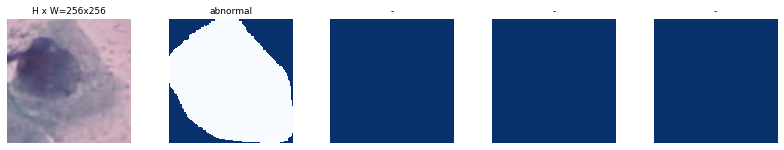

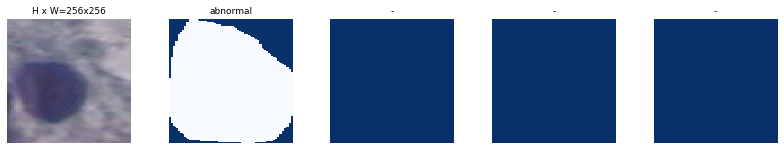

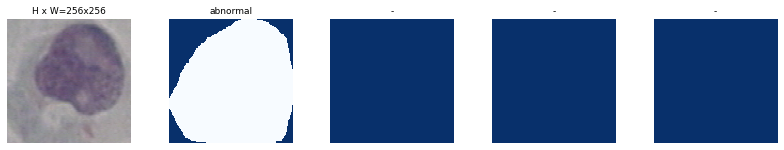

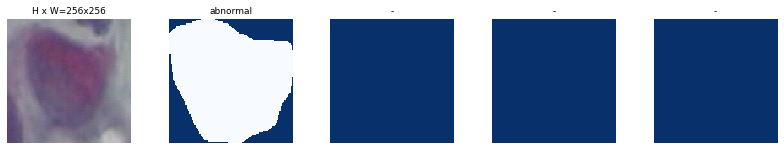

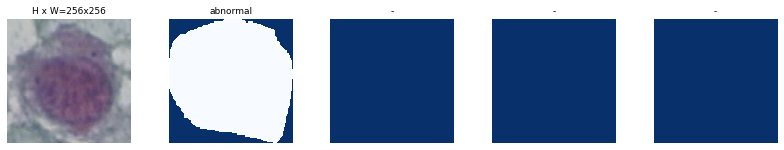

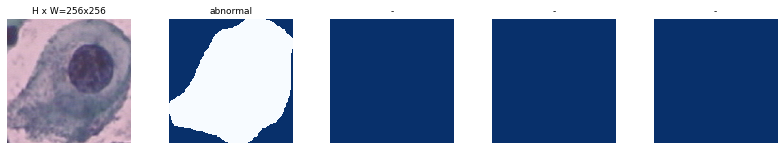

In [11]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids,6)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)


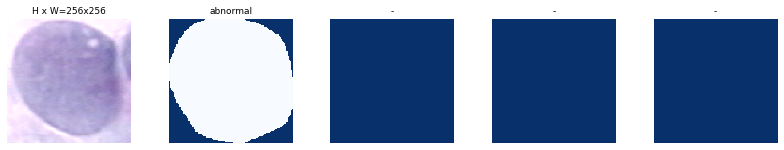

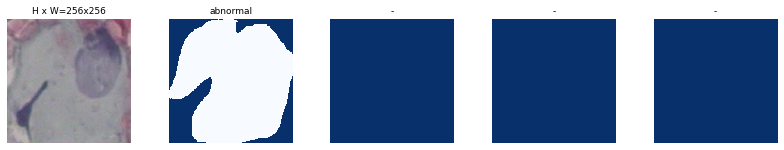

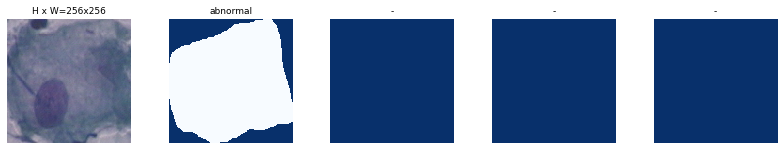

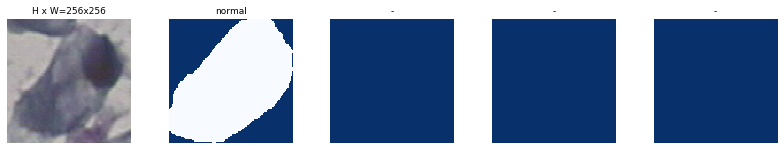

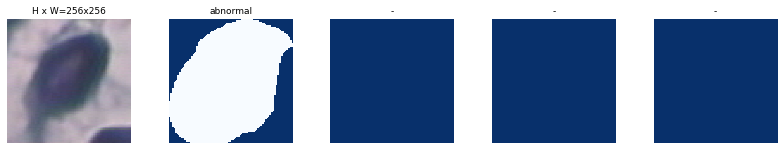

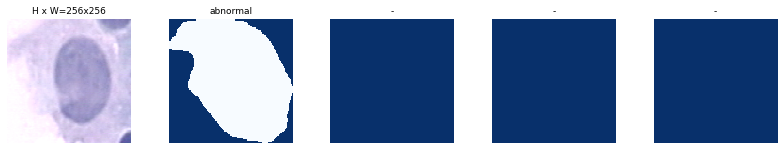

In [12]:
dataset = dataset_val
image_ids = np.random.choice(dataset.image_ids,6)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [0]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [0]:
# Which weights to start with?
# init_with = "coco"  # imagenet, coco, or last
init_with = "coco"
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [0]:
from keras.callbacks import ModelCheckpoint
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
filepath=" /content/drive/My Drive/binaug_logs/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(model.checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=True, mode='min')

callbacks_list = [checkpoint]


start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=40, 
            augmentation= seq,
            custom_callbacks= callbacks_list,
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')

In [0]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.

# start_train = time.time()
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=8, 
#             layers="all")
# end_train = time.time()
# minutes = round((end_train - start_train) / 60, 2)
# print(f'Training took {minutes} minutes')

In [0]:
class InferenceConfig(Cervic_binary_augConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    # DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_MIN_CONFIDENCE = 0.4

inference_config = InferenceConfig()

In [0]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '/content/drive/My Drive/'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
from mrcnn import visualize1
import mrcnn.model1 as modellib

In [15]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR )








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [19]:


# Get path to saved weights

# Either set a specific path or find last trained weights
COCO_MODEL_PATH= '/content/drive/My Drive/binaug_logs/cervic_binary_aug_five20200127T0402/mask_rcnn_cervic_binary_aug_five_0091.h5'
model_path = os.path.join(ROOT_DIR, COCO_MODEL_PATH )
#model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/binaug_logs/cervic_binary_aug_five20200127T0402/mask_rcnn_cervic_binary_aug_five_0091.h5
Re-starting from epoch 91


In [0]:

def class_find(cl_id):

      names=  { 
                              '1': 'normal',
                              '2': 'abnormal' 
                              
                      }
      return names.get(cl_id)

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153828952-153828980-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


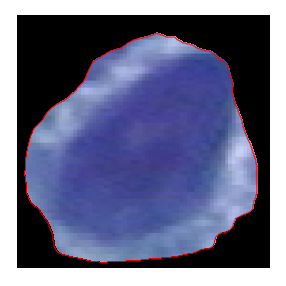

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153915432-153915472-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


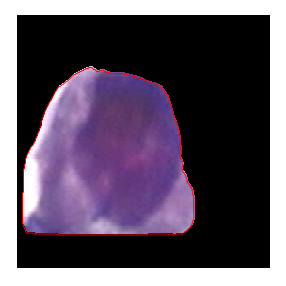

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153831027-153831036-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


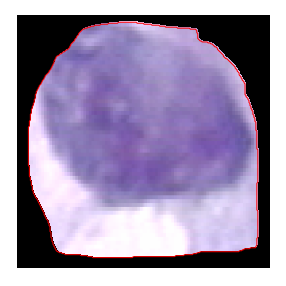

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153657599-153657622-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   53.00000  max:  209.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:   95.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


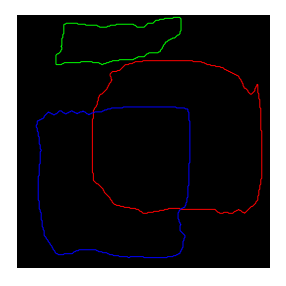

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/204870926-204870933-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   79.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -44.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


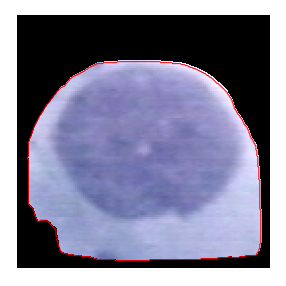

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153701949-153701958-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   46.00000  max:  191.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:   86.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


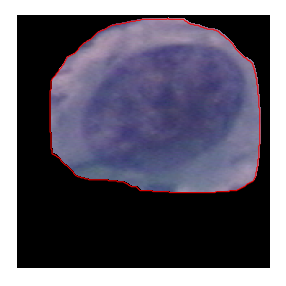

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153700207-153700224-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   69.00000  max:  199.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -47.80000  max:   90.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


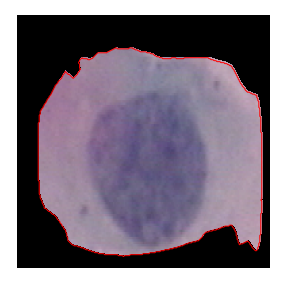

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153915634-153915665-005.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -63.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


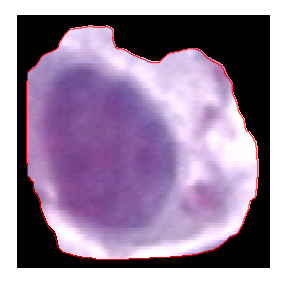

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153829745-153829768-003.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   70.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -46.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


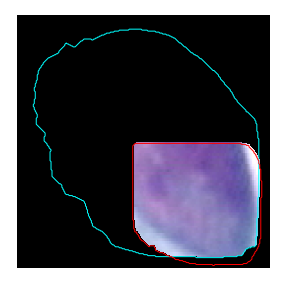

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153831352-153831372-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -63.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


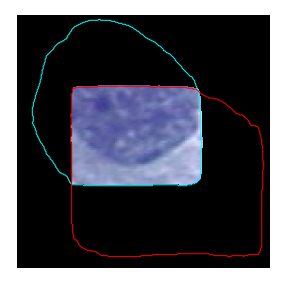

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/204870951-204870961-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   28.00000  max:  231.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  118.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


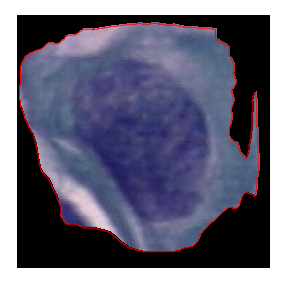

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153831471-153831486-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


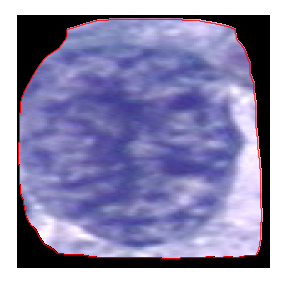

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153827595-153827664-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -63.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


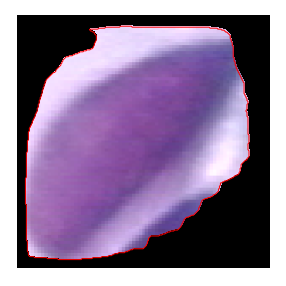

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153702037-153702051-003.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   88.00000  max:  202.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -35.70000  max:   96.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


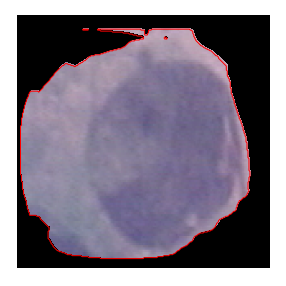

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153916114-153916150-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -78.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


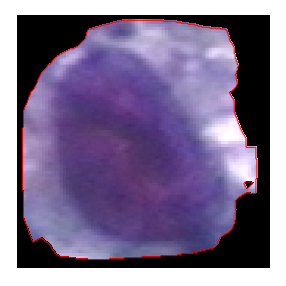

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153829063-153829073-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:  110.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:   -6.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


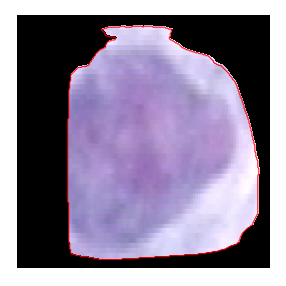

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153831471-153831479-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


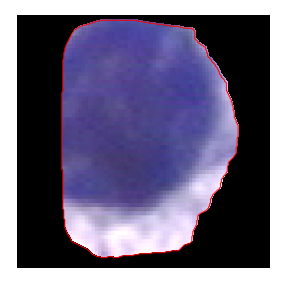

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153829063-153829086-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


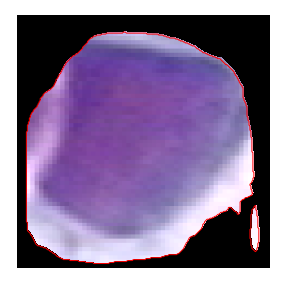

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/204871030-204871038-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   34.00000  max:  199.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -84.70000  max:   82.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


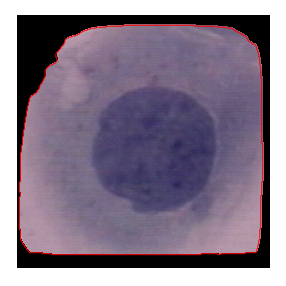

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153915316-153915330-003.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


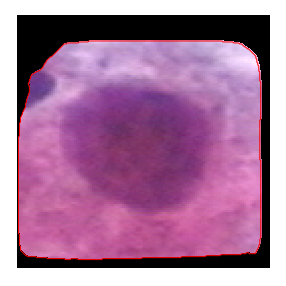

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153657698-153657708-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   75.00000  max:  205.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.70000  max:   92.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


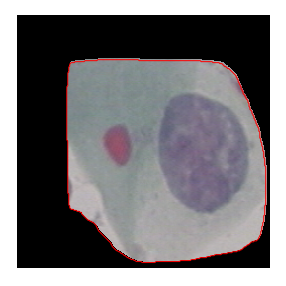

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153916114-153916167-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


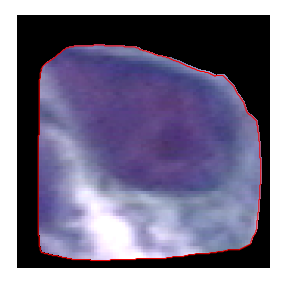

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153697097-153697106-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   62.00000  max:  209.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -54.80000  max:   95.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


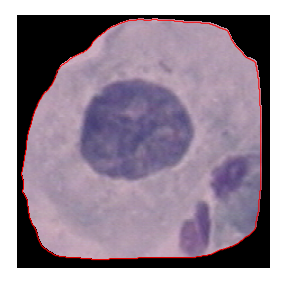

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153916114-153916167-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   41.00000  max:  215.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.80000  max:  111.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


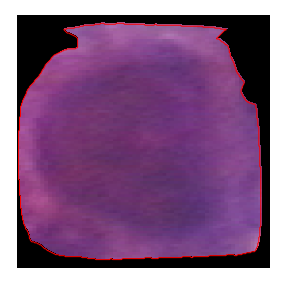

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153829063-153829073-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   54.00000  max:  212.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -63.70000  max:  105.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


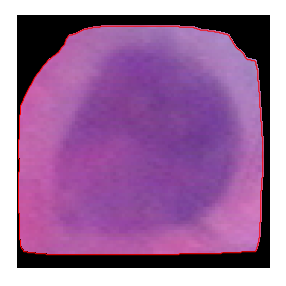

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153701139-153701148-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   44.00000  max:  208.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.80000  max:   95.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


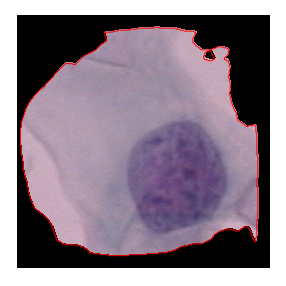

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153831352-153831372-004.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   66.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -57.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


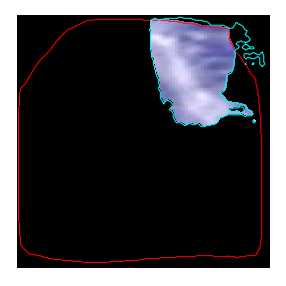

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153698259-153698268-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   54.00000  max:  205.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:   95.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


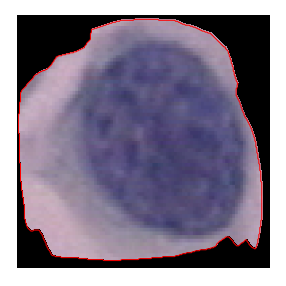

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/154519964-154519981-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   59.00000  max:  205.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -62.70000  max:   90.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


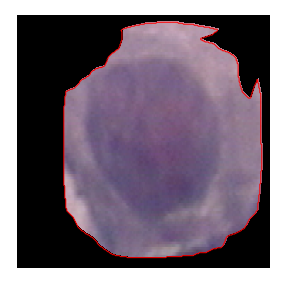

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/149316426-149316462-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   74.00000  max:  202.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -47.70000  max:   98.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


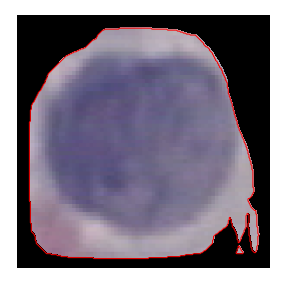

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153830261-153830340-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   40.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -83.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


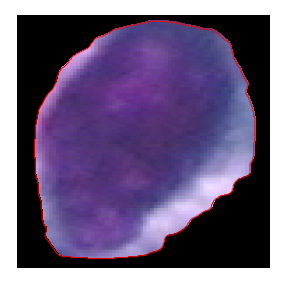

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153276799-153276818-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   64.00000  max:  213.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -54.70000  max:   96.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


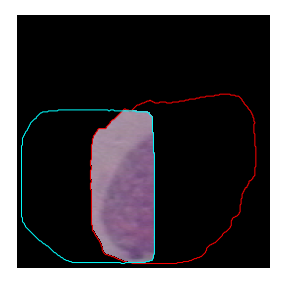

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/204870951-204870961-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   28.00000  max:  227.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -95.70000  max:  120.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


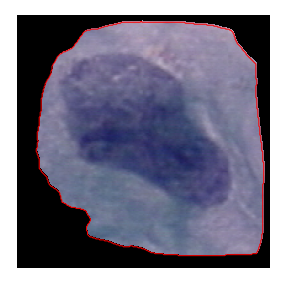

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153698259-153698268-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   52.00000  max:  209.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:  105.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


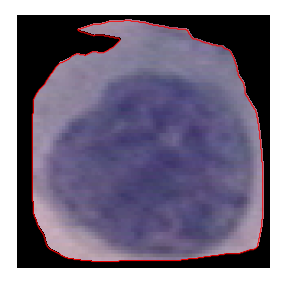

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153831027-153831045-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -63.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


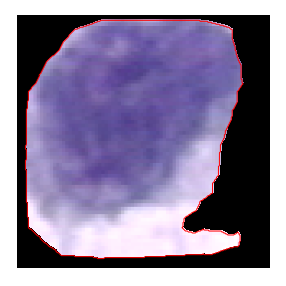

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153829745-153829754-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


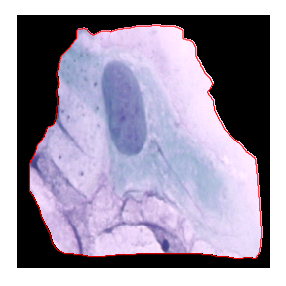

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153831471-153831486-004.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   76.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -45.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
1
Predicted class :normal Actual class :abnormal


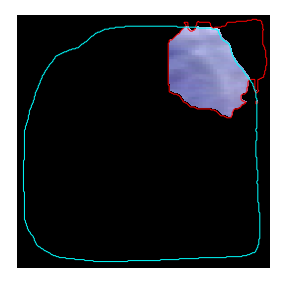

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153697726-153697736-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   61.00000  max:  201.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -55.80000  max:   89.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


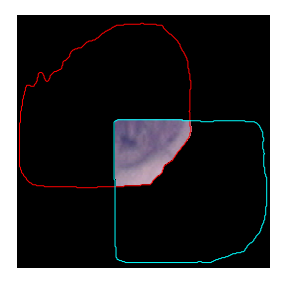

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153702037-153702060-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   52.00000  max:  211.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -64.80000  max:   99.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


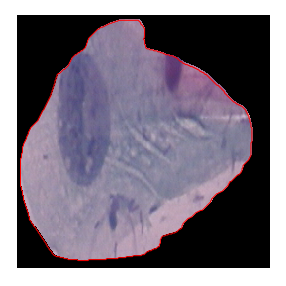

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153915726-153915736-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   43.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
1
Predicted class :normal Actual class :abnormal


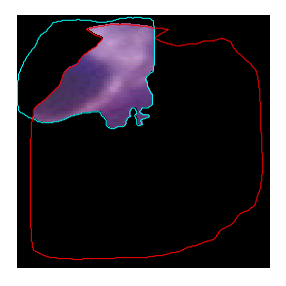

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153916114-153916129-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


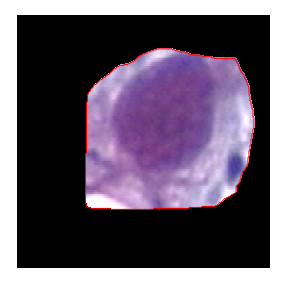

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153700207-153700215-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   62.00000  max:  207.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -56.70000  max:   88.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


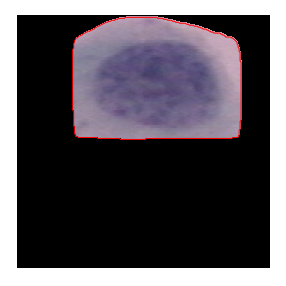

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153276386-153276414-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   80.00000  max:  205.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -36.80000  max:   84.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


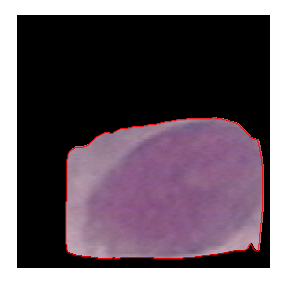

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/204871030-204871038-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  189.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -108.70000  max:   75.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


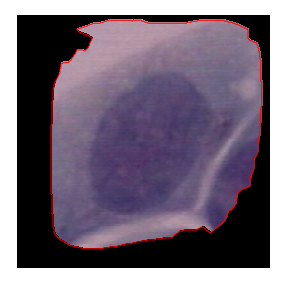

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/204870892-204870902-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:    6.00000  max:  162.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -110.80000  max:   58.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


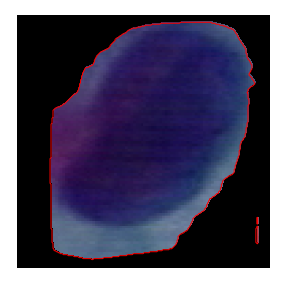

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/204870926-204870933-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   39.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


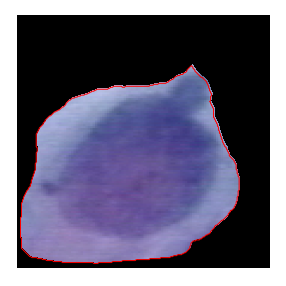

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153697342-153697384-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   60.00000  max:  189.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -61.70000  max:   85.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


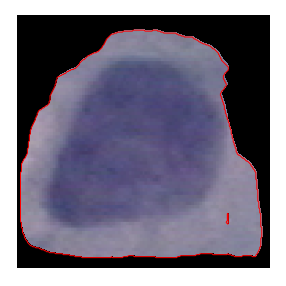

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153831471-153831486-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   78.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -45.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


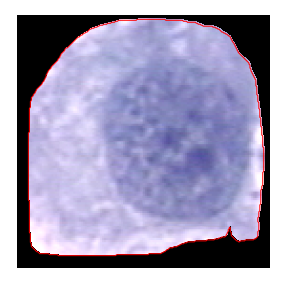

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153697342-153697375-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   64.00000  max:  191.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -59.70000  max:   87.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


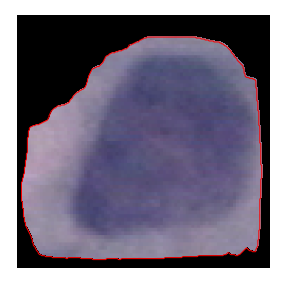

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153276386-153276405-004.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   68.00000  max:  213.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -53.70000  max:   94.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


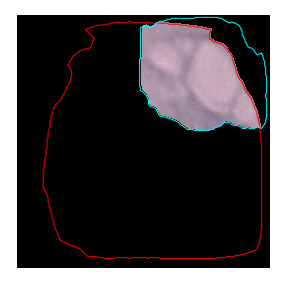

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153830680-153830827-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


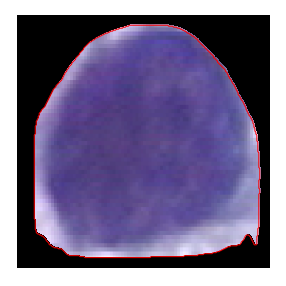

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153701557-153701566-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   53.00000  max:  211.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  103.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


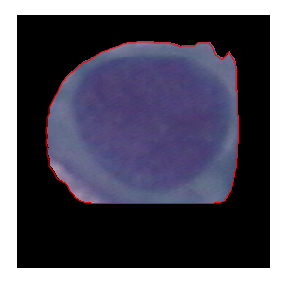

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153697342-153697375-003.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   55.00000  max:  199.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:   91.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


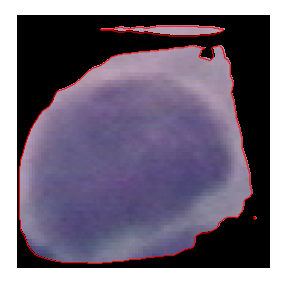

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153702037-153702051-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   60.00000  max:  200.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -57.70000  max:   94.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


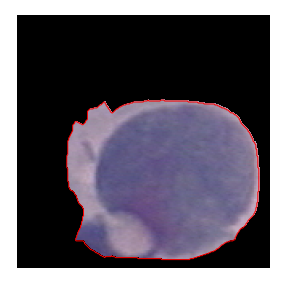

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/204870858-204870872-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


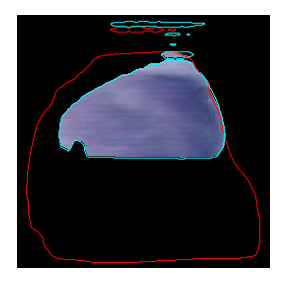

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153657327-153657363-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   51.00000  max:  206.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:   96.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


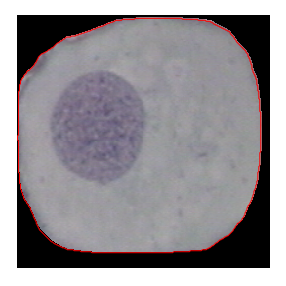

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153829664-153829672-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   75.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -41.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


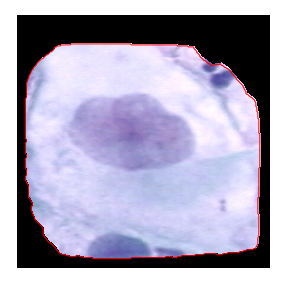

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153697342-153697366-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   79.00000  max:  201.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -44.70000  max:   93.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


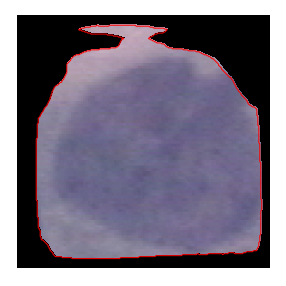

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/154520056-154520096-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   44.00000  max:  213.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:   94.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


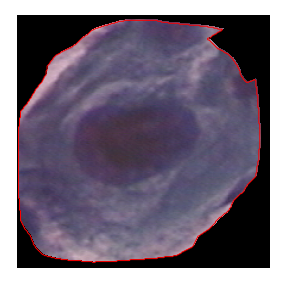

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153697342-153697384-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   61.00000  max:  203.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -62.70000  max:   91.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


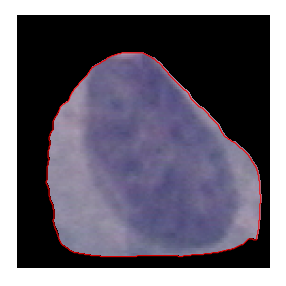

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153828952-153829005-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   47.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -76.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


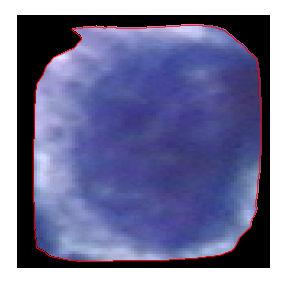

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153828952-153829005-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


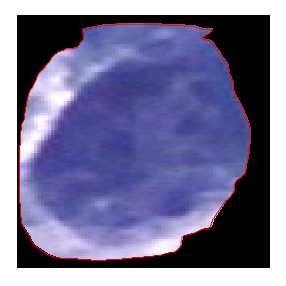

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153698259-153698268-003.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   50.00000  max:  213.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  103.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


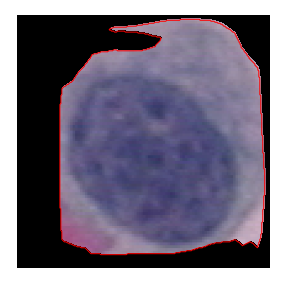

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153829700-153829705-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


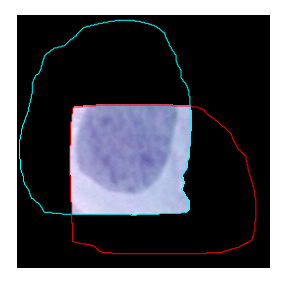

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153828952-153829009-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


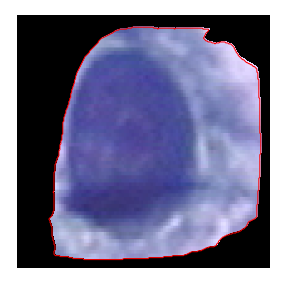

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153831352-153831372-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   53.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


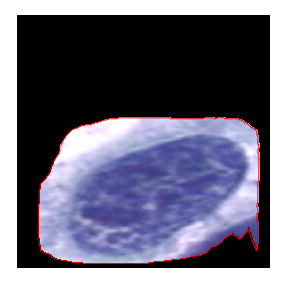

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153828952-153828970-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   34.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -82.80000  max:  148.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


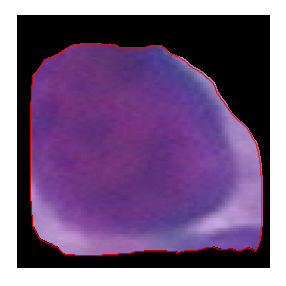

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153830680-153830827-003.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


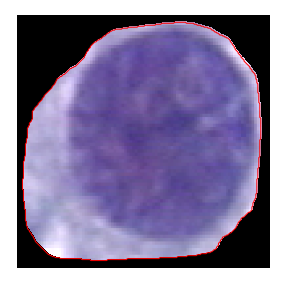

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153701139-153701158-005.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   50.00000  max:  181.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:   77.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


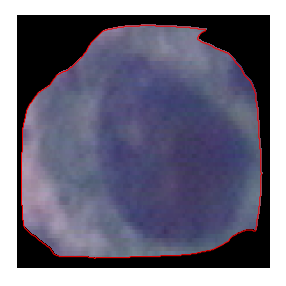

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153828877-153828902-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   55.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


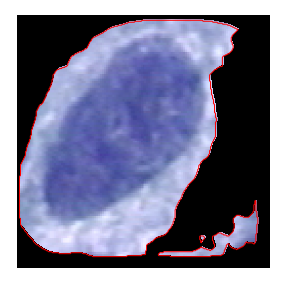

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153657599-153657610-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   60.00000  max:  193.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -63.70000  max:   79.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


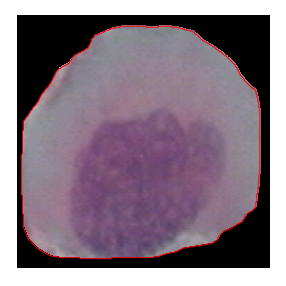

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153697342-153697353-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   74.00000  max:  199.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -49.70000  max:   86.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


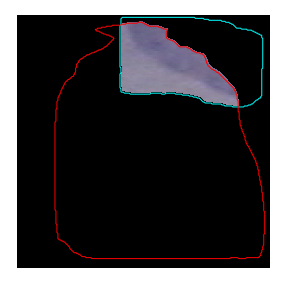

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153915726-153915774-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


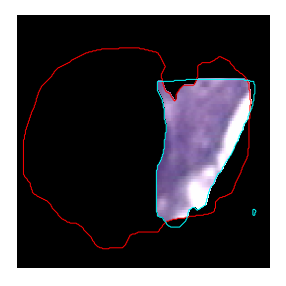

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/149357956-149358043-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   42.00000  max:  196.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -74.80000  max:   80.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


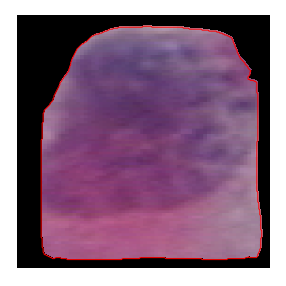

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153916001-153916020-003.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   59.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -59.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


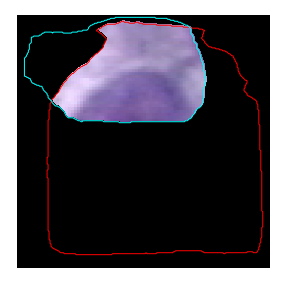

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153276386-153276405-003.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   58.00000  max:  209.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -58.80000  max:   89.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


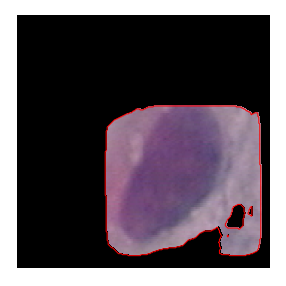

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153697342-153697366-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   52.00000  max:  203.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:   92.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


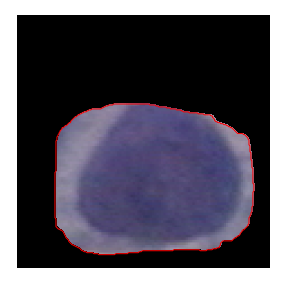

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153828952-153829000-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   52.00000  max:  226.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -71.70000  max:  122.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


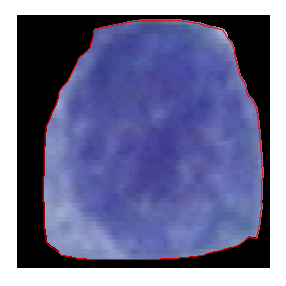

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153831352-153831372-003.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   58.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -65.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


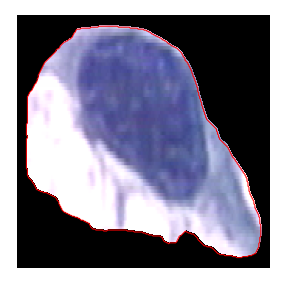

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153829745-153829763-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   83.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -39.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


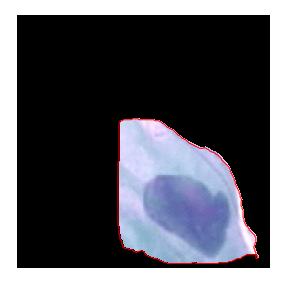

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153916675-153916684-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   52.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


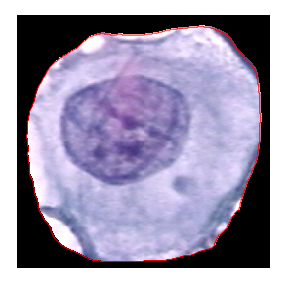

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153701139-153701158-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   42.00000  max:  218.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  100.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


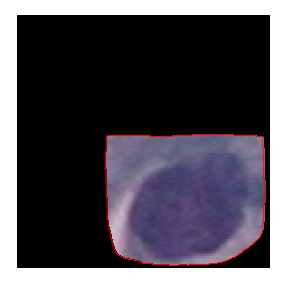

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153826597-153826619-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -60.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


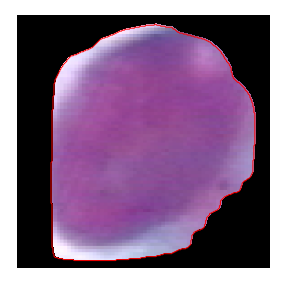

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/204870815-204870836-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   42.00000  max:  234.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:  130.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


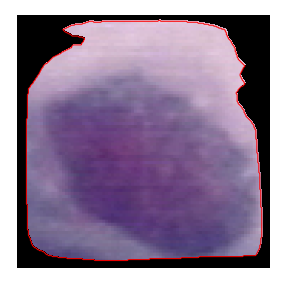

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153701949-153701964-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   42.00000  max:  186.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -81.70000  max:   81.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


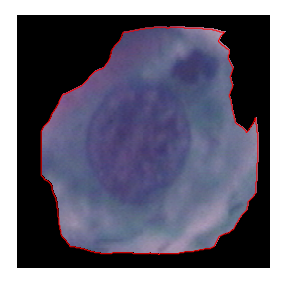

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153826597-153826619-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   72.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -44.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


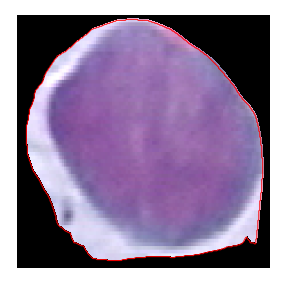

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153915432-153915441-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   60.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -56.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


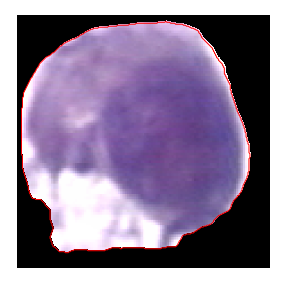

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153915634-153915665-003.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


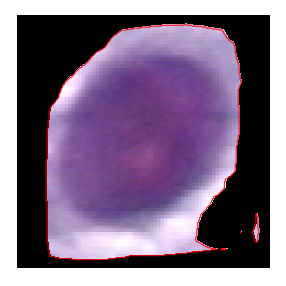

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153701139-153701158-003.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   51.00000  max:  213.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:   97.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


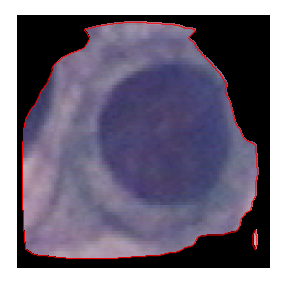

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153827595-153827657-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   65.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -58.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


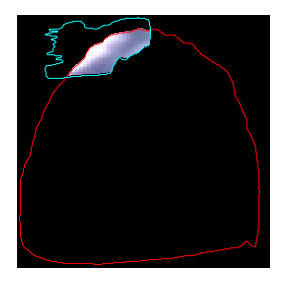

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153915634-153915665-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   62.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -54.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


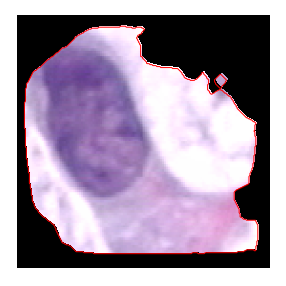

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153829664-153829678-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   55.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.70000  max:  148.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


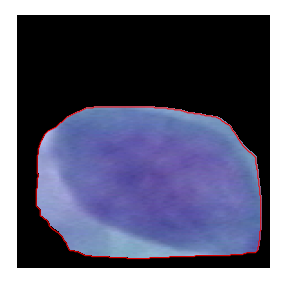

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153915634-153915665-007.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -64.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


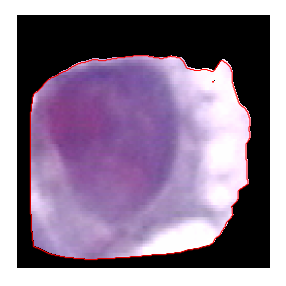

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153831426-153831438-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   64.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -52.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


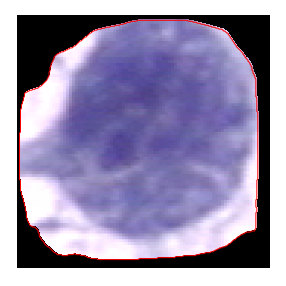

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153701622-153701650-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   56.00000  max:  196.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -67.70000  max:   91.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


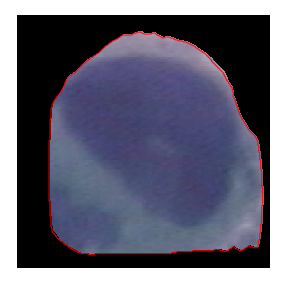

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153701009-153701019-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   46.00000  max:  215.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  102.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


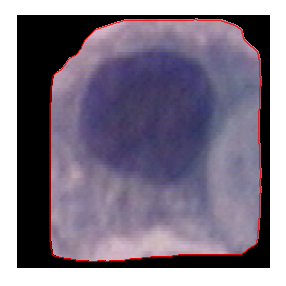

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153657599-153657610-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   51.00000  max:  189.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:   69.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


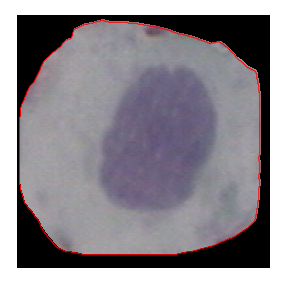

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153830261-153830340-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


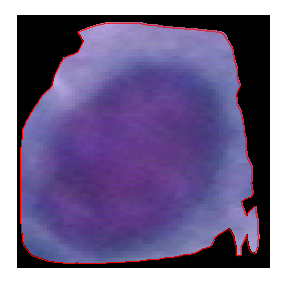

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/149316426-149316462-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   62.00000  max:  199.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -61.70000  max:   91.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


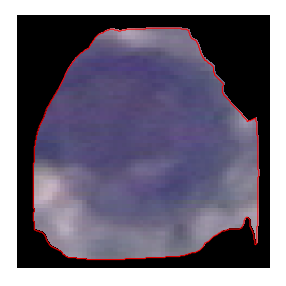

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/149316426-149316462-004.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   76.00000  max:  200.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -47.70000  max:   96.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
1
Predicted class :normal Actual class :abnormal


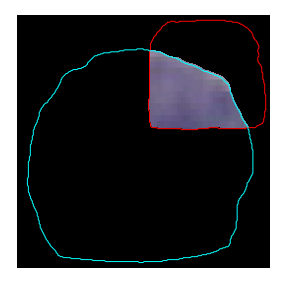

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153829700-153829711-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   66.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -57.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


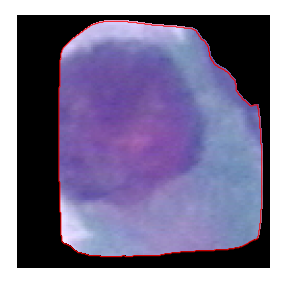

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153831027-153831045-003.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


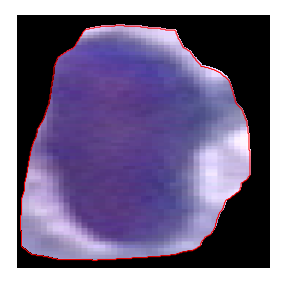

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153829063-153829078-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   52.00000  max:  215.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -64.80000  max:  104.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


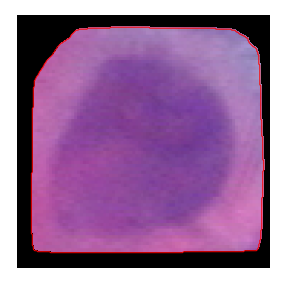

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153831471-153831486-003.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   68.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -52.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


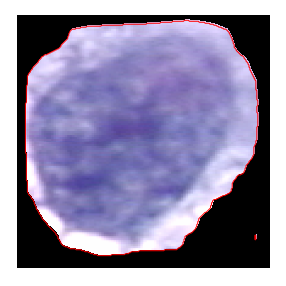

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153657419-153657488-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   57.00000  max:  205.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.70000  max:   94.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


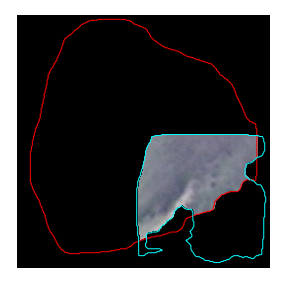

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153827595-153827657-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   62.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -57.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


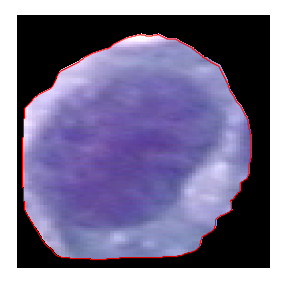

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/149317114-149317152-004.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   53.00000  max:  201.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -63.80000  max:   95.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


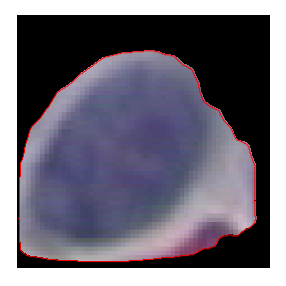

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153701139-153701158-004.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   48.00000  max:  195.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -75.70000  max:   91.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


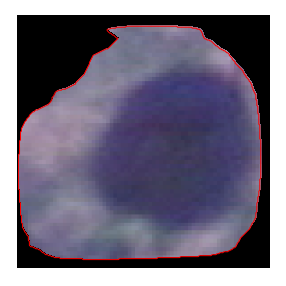

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153701009-153701019-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   50.00000  max:  209.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:   93.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


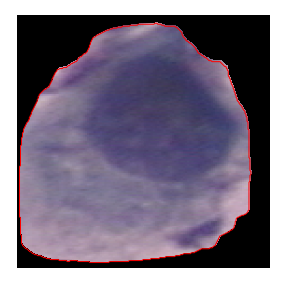

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153828952-153829000-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   54.00000  max:  228.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  124.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


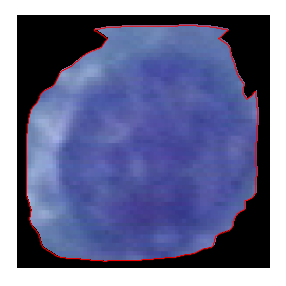

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/204870858-204870872-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -77.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


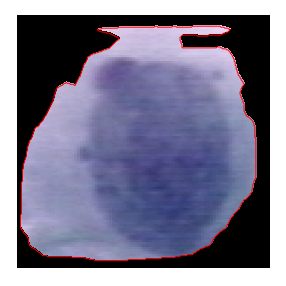

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153828952-153829000-003.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -69.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


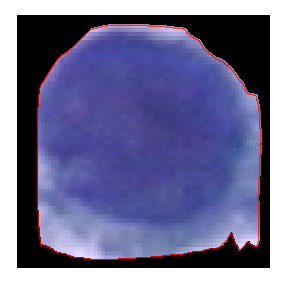

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/149317114-149317152-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   58.00000  max:  210.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -65.70000  max:  106.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


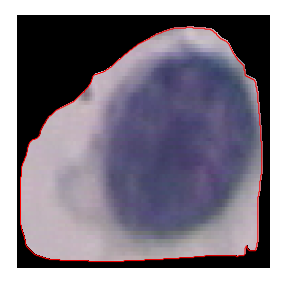

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153831027-153831045-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -62.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


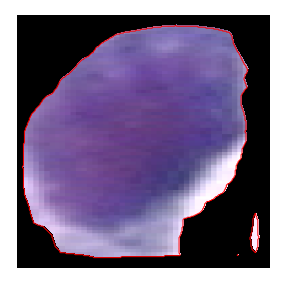

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153915634-153915665-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   46.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -70.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


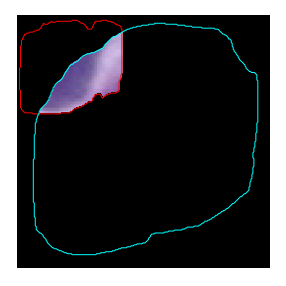

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153916922-153916963-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   45.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


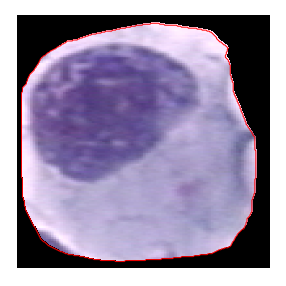

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153916001-153916020-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   64.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -59.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


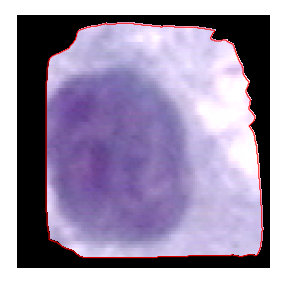

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153830680-153830693-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   44.00000  max:  252.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  148.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


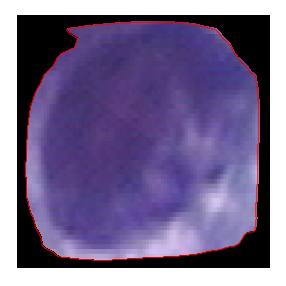

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153916569-153916586-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   44.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -79.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


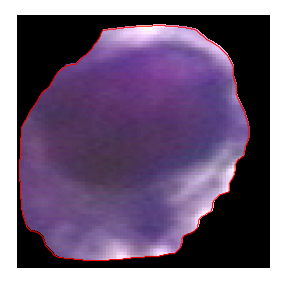

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/204870892-204870910-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   22.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -101.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


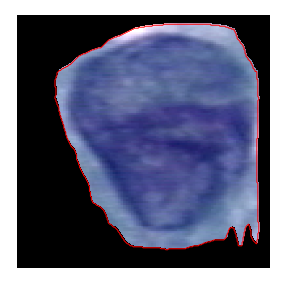

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/204870815-204870836-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   30.00000  max:  239.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -93.70000  max:  129.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


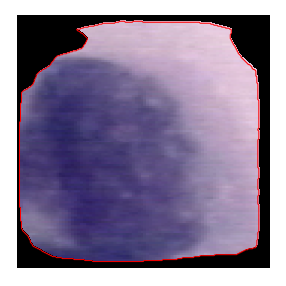

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153657599-153657633-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   67.00000  max:  188.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -49.80000  max:   81.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


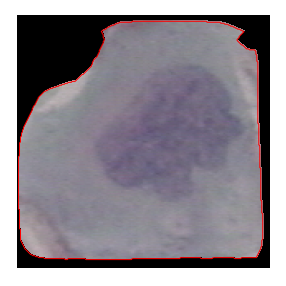

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153702037-153702051-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   70.00000  max:  203.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -53.70000  max:   90.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


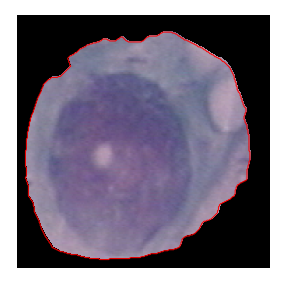

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/149317114-149317152-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   51.00000  max:  216.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -72.70000  max:  106.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


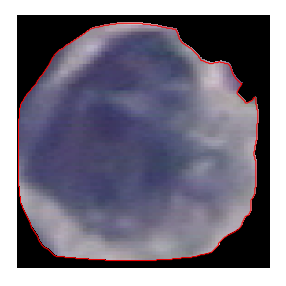

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/149316426-149316462-003.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   61.00000  max:  211.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -62.70000  max:  105.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


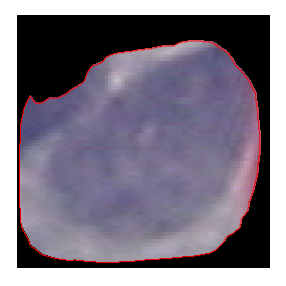

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153831027-153831036-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   48.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -68.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


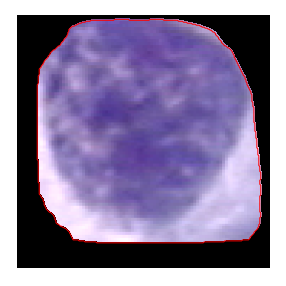

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153829745-153829768-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   62.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -54.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


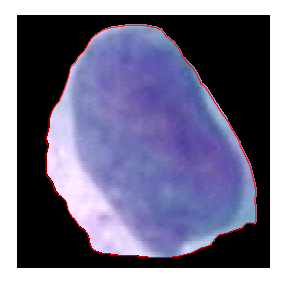

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153830680-153830827-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   54.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -62.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


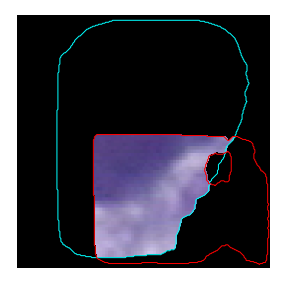

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153915230-153915252-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -73.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


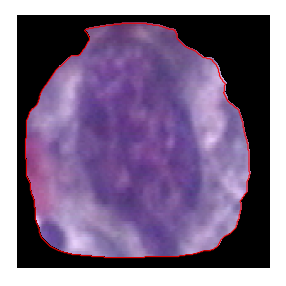

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153829745-153829768-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


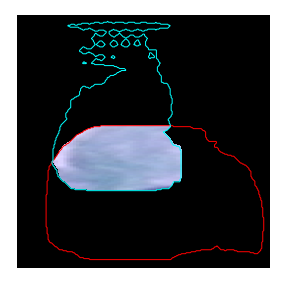

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153915634-153915665-006.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   50.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -66.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


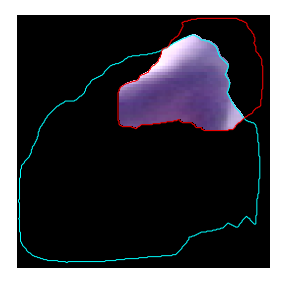

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153657419-153657488-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   83.00000  max:  199.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -40.70000  max:   87.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


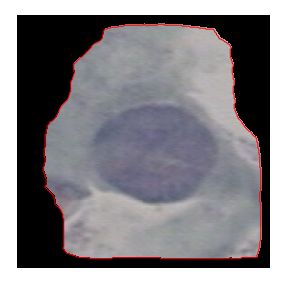

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153697342-153697375-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   65.00000  max:  183.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -58.70000  max:   79.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


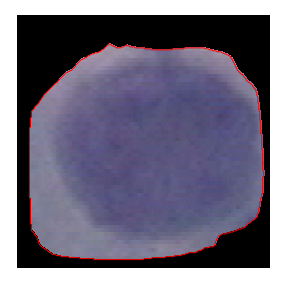

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153827595-153827669-001.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   68.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -48.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


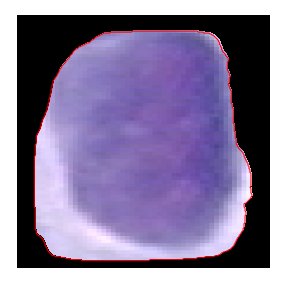

filename:/content/drive/My Drive/bin_cervic_test_resize/abnormal/153657599-153657633-002.BMP
Processing 1 images
image                    shape: (256, 256, 3)         min:   85.00000  max:  151.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -38.70000  max:   45.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
2
Predicted class :abnormal Actual class :abnormal


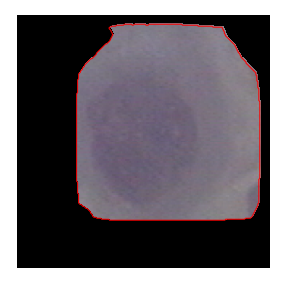

Total no. of images in  abnormal   is   135
No. of images correctly classified is   132
Accuracy  of class:   abnormal  is  97.77777777777777


In [23]:
import skimage
import cv2

save_dir = '/content/drive/My Drive/Maskrcnn_seg/abnormal/'
real_test_dir = '/content/drive/My Drive/bin_cervic_test_resize/abnormal'
col=['White']
acc=0
image_paths = []
file_count=0
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1] in ['.png', '.jpg', '.jpeg','.BMP']:
        image_paths.append(os.path.join(real_test_dir, filename))
        file_count=file_count+1

for image_path in image_paths:
    print('filename:'+image_path)
    filename=image_path.split('/')[6]
    # print('filename:'+filename)
    savepath1=save_dir+filename
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    # print(r['masks'])
    print(r['class_ids'][0])
    class_name=class_find(str(r['class_ids'][0]))
    actual_class= real_test_dir.rsplit('/', 1)[1]
    if class_name==actual_class:
      acc=acc+1
    print('Predicted class :' +class_name + ' Actual class :'+actual_class)
    visualize1.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, savepath1, show_mask=True, show_bbox=False, captions=None, figsize=(5,5))
    # print(im)
   
    # print(savepath1)
    # cv2.imwrite(savepath,im)
    # visualize.apply_mask(img, r['masks'], '0', alpha=0.5)
print('Total no. of images in ',actual_class, '  is  ', file_count)
print('No. of images correctly classified is  ', acc)
accper=(acc/file_count) *100
print('Accuracy  of class:  ' , actual_class, ' is ', str(accper))

In [0]:
# import skimage
# real_test_dir = '/content/drive/My Drive/bin_cervic_test/normal'
# image_paths = []
# for filename in os.listdir(real_test_dir):
#     if os.path.splitext(filename)[1] in ['.png', '.jpg', '.jpeg','.BMP']:
#         image_paths.append(os.path.join(real_test_dir, filename))

# for image_path in image_paths:
#     print('filename:'+image_path)
#     img = skimage.io.imread(image_path)
#     img_arr = np.array(img)
#     results = model.detect([img_arr], verbose=1)
#     r = results[0]
#     visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
#                                 dataset_val.class_names, r['scores'], figsize=(5,5))

In [0]:
import skimage
real_test_dir = '/content/drive/My Drive/bin_cervic_test_resize/abnormal'

acc=0
image_paths = []
file_count=0
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1] in ['.png', '.jpg', '.jpeg','.BMP']:
        image_paths.append(os.path.join(real_test_dir, filename))
        file_count=file_count+1

for image_path in image_paths:
    print('filename:'+image_path)
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    print(r['class_ids'][0])
    class_name=class_find(str(r['class_ids'][0]))
    actual_class= real_test_dir.rsplit('/', 1)[1]
    if class_name==actual_class:
      acc=acc+1
    print('Predicted class :' +class_name + ' Actual class :'+actual_class)
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, figsize=(5,5))
print('Total no. of images in ',actual_class, '  is  ', file_count)
print('No. of images correctly classified is  ', acc)
accper=(acc/file_count) *100
print('Accuracy  of class:  ' , actual_class, ' is ', str(accper))